In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm.notebook import tqdm

In [2]:
nas_path = "./dataset_1401/"
lineage_label = np.array(pd.read_csv('./dataset_1401/1404_lineage_report and metadata 20220316.csv')[['lineage_x','diff']])
label_ = []
new_lineage_label = []
for idx, rna in enumerate(SeqIO.parse('./dataset_1401/1404.sequences.aln.fasta',"fasta")):
    if "B.1.617.2" == lineage_label[idx][0]:
    # break
    # print(lineage_label[idx][0].split(' ')[0])
        label_.append(lineage_label[idx][1].split(' ')[0])

        new_lineage_label.append(str(rna.seq))
print('sample:', len(new_lineage_label))

sample: 1135


In [3]:
class_,_ ,_,_= np.unique(label_,return_counts=True,return_index=True,return_inverse=True)
print(class_)

['N' 'Y']


In [4]:
# # only tcga rna unit
def clean(x):
	x = x.upper() 
	
	if x == 'T' or x == 'A' or x == 'G' or x == 'C' or x == '-' or x == 'N':
		return x

	if x == 'U' or x == 'Y':
		return 'T'
	
	if x == 'K' or x == 'S':
		return 'G'

	if x == 'M' or x == 'R' or x == 'W' or x == 'H' or x=='V' or x=='D':
		return 'A'

	if x== 'B':
		return 'C'
from itertools import product
dict_search = {}
for idx, i in enumerate('-NACGT'):

    dict_search[i] = idx
print(dict_search)
from tqdm.notebook import tqdm
num_new_sequences =[]
for k in tqdm(new_lineage_label):
	temp_store=[]
	for j in k:
		temp_store.append(clean(j)) #one hot
		# temp_store.append(dict_search[clean(j)])
	num_new_sequences.append(temp_store)
total_sequence_array = np.array(num_new_sequences)
print(total_sequence_array.shape)

{'-': 0, 'N': 1, 'A': 2, 'C': 3, 'G': 4, 'T': 5}


  0%|          | 0/1135 [00:00<?, ?it/s]

(1135, 29903)


In [5]:
del new_lineage_label, num_new_sequences
new_lineage_label = total_sequence_array
one_hot_search_dict = {'C': [1,0,0,0,0,0], 'G': [0,1,0,0,0,0], 'A': [0,0,1,0,0,0],  'T': [0,0,0,1,0,0], 'N': [0,0,0,0,1,0],  '-': [0,0,0,0,0,1]}

num_new_sequences =[]
for k in tqdm(new_lineage_label):
	temp_single_seq_transfer = []
	for j in k:
		temp_single_seq_transfer+=one_hot_search_dict[j]
	num_new_sequences.append(temp_single_seq_transfer)
total_sequence_array = np.array(num_new_sequences)
print(total_sequence_array.shape)


  0%|          | 0/1135 [00:00<?, ?it/s]

(1135, 179418)


In [6]:
class_dict_ = {}
for idx, i in enumerate(class_):
    class_dict_[i] = idx
print(class_dict_)
multi_label = []
for i in label_:
    multi_label.append(class_dict_[i])

{'N': 0, 'Y': 1}


In [7]:
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
ln = LogScaler()
X_train_norm = ln.fit_transform(total_sequence_array)
# tsne = TSNE(n_components=2, perplexity=30, metric='cosine',
#             random_state=1701, n_jobs=-1)
            
# it =  ImageTransformer(feature_extractor=tsne, pixels=100)
# X_train_img = it.fit_transform(X_train_norm)

In [8]:
# save fiter matrix
import pickle as pk
# pk.dump(it, open("tsne_try-get-model-matrix.pkl","wb"))
tsne_reload = pk.load(open("tsne_try-get-model-matrix.pkl",'rb'))
result_new = tsne_reload .transform(X_train_norm[0:4])

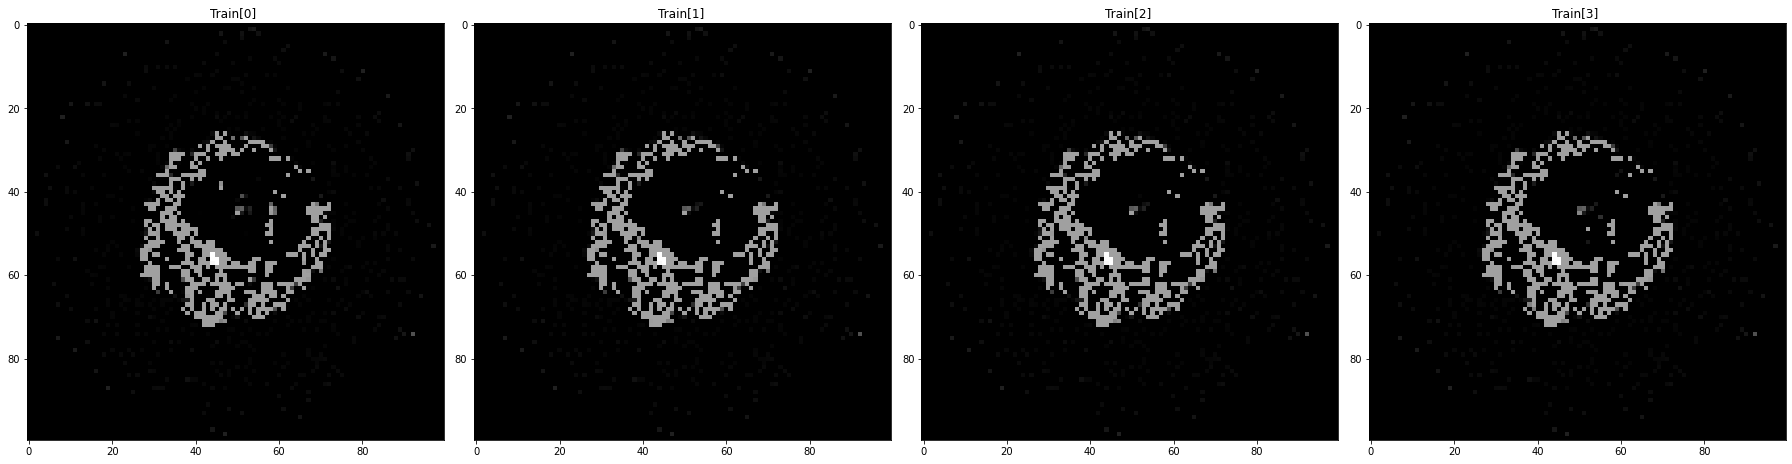

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
for i in range(0,4):
    ax[i].imshow(result_new[i])
    ax[i].title.set_text("Train[{}] ".format(i))
plt.tight_layout()

In [11]:
print(it.feature_density_matrix().shape)
print(it.coords().shape)

(440, 440)
(179418, 2)


In [12]:
# np.save("deepinsight_location_npy/feature_density_matrix_[NACGTRYKMSWBDHV]-multiclass=1404.npy",it.feature_density_matrix())
# np.save("deepinsight_location_npy/coords_[NACGTRYKMSWBDHV]-multiclass=1404.npy",it.coords())
np.save("deepinsight_location_npy/feature_density_matrix_[NACGT]-binaryclass=1135_onehoe440px.npy",it.feature_density_matrix())
np.save("deepinsight_location_npy/coords_[NACGT]-binaryclass=1135_onehoe440px.npy",it.coords())

In [13]:
# multiclass_nactg multiclass_totalunit
save_path = './np_image_totalunit/binaryclass_nactg_onehoe440px/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
if not os.path.exists(os.path.join(save_path,'image_npy')):
    os.mkdir(os.path.join(save_path,'image_npy'))

np.save(f'{save_path}/label.npy',multi_label)
for idx, image in enumerate(X_train_img):
    if (idx)<10:
        np.save(f"{save_path}/image_npy/000{idx}.npy", image)
    elif (idx)<100:
        np.save(f"{save_path}/image_npy/00{idx}.npy", image)
    elif (idx)<1000:
        np.save(f"{save_path}/image_npy/0{idx}.npy", image)
    else:
        np.save(f"{save_path}/image_npy/{idx}.npy", image)


In [14]:
# fig, ax = plt.subplots(1, 4, figsize=(25, 7))
# for i in range(0,4):
#     ax[i].imshow(X_train_img[i], cmap='bone')
#     ax[i].title.set_text("Train[{}] - class '{}'".format(i, ""))
# plt.tight_layout()

In [15]:
# from PIL import Image

# new_p = Image.fromarray((X_train_img[0]*255).astype(np.uint8))
# if new_p.mode != 'RGB':
#     new_p = new_p.convert('RGB')
# new_p.save("filename.png")

In [16]:
# fig, ax = plt.subplots(1, 4, figsize=(25, 7))
# for i in range(0,4):
#     ax[i].imshow(X_train_img[i][:,:,0], cmap='bone')
#     ax[i].title.set_text("Train[{}] - class '{}'".format(i, ""))
# plt.tight_layout()

In [17]:
from PIL import Image
